#### Load required libraries

In [1]:
import random
random.seed(123)

import sys, os
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

sys.path.append('../')
import functions.pyVISCOUS as vs


#### Load local functions

In [2]:
def Sobol_function(x, a):
    ''' Sobol function
    -------
    x: input array, shape (nSample,nVar).
    a: input array, shape (nSample,nVar).
    y: output array, shape (nSample,1).'''
    
    subPart = np.abs(4*x-2)
    y = np.prod((subPart+a)/(1+a), axis=1) 

    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

def plot_gmm_mean_cov(gmm, var_name_ls, sensType, GSA_idx, ofile):
    
    '''Plot GMM mean and covariance estiamtes for a specific evaluated variable group.
    -------
    gmm:         input object. The best fitted Gaussian mixture model (GMM) used by a specific variable group.
    var_name_ls: input list. The complete list of (x,y) variables names.
    sensType:    input str. Type of Sensitivity index calculation. Two options: 'first', 'total'.
    GSA_idx:     input list. List of x variable indices of a specific variable group. eg, [0], or [1], or [2].     
    ofile:       output figure file path. '''

    import matplotlib.colors as colors    

    # specify GMM information
    gmmWeights     = gmm.weights_            # shape (n_components,)
    gmmMeans       = gmm.means_              # shape (n_components, n_variables). 
    gmmCovariances = gmm.covariances_        # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
    gmmNComponents = gmm.n_components        # number of components
    (n_components, n_variables) = np.shape(gmmMeans)

    # define xticklabels based on variable name list (var_name_ls)    
    if sensType == 'first':   # select elements
        xticklabels = [var_name_ls[idx] for idx in GSA_idx] 
        xticklabels.append(var_name_ls[-1])
    elif sensType == 'total': # delete elements 
        xticklabels = var_name_ls
        for idx in GSA_idx:
            xticklabels.pop(idx)
    fs='medium'                                                                      # text fontsize
    markers = ['o', 'v', 's', '*', '^', 'D', 'p', '>', 'h', 'H', '<', 'd', 'P', 'X'] # a list of markers for Gaussian mean plot
    axes = []                                                                        # collect a list of axes to insert the colorbar

    # create a figure
    ncol = 3
    nrow = 1+int(np.ceil(gmmNComponents/ncol))
    fig = plt.figure(figsize=(3*ncol,3*nrow), constrained_layout=True)

    # divide figure into grids
    heights = [1]
    for i in np.arange(1,nrow):
        heights.append(1.1)
    gs = gridspec.GridSpec(nrows=nrow, ncols=ncol, figure=fig, height_ratios=heights)

    # plot Gaussian mean
    iRow = 0            
    ax = fig.add_subplot(gs[iRow, :])
    for i in range(gmmNComponents):
        ax.scatter(range(1,1+n_variables),gmmMeans[i,:],label='Cpnt '+str(i+1), alpha=0.7, marker=markers[i%len(markers)])

    ax.set_xticks(range(1,1+n_variables))
    ax.set_xticklabels(xticklabels, fontsize=fs)
    ax.set_ylabel('Mean', fontsize=fs)

    ax.tick_params(axis='x', labelsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    ax.legend(loc='best', ncol=3, fontsize='small',framealpha=0.5)  
    ax.set_title('(a) Means of all Cpnts', fontsize=fs)

    # plot Gaussian covariance
    for i in range(gmmNComponents):
        iRow      = i//ncol + 1
        iCol      = i%ncol
        ax        = fig.add_subplot(gs[iRow, iCol])

        vmin,vmax = -1.01,1.01
        norm      = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        aa        = ax.imshow(gmmCovariances[i,:,:],cmap='bwr', norm=norm)

        ax.set_xticks(range(n_variables))
        ax.set_xticklabels(xticklabels, fontsize=fs)

        ax.set_yticks(range(n_variables))
        ax.set_yticklabels(xticklabels, fontsize=fs)
        ax.set_title('(%s) Covariance of Cpnt %d'%(chr(ord('b')+i), (i+1)), fontsize=fs)

        # colorbar setup
        axes.append(ax)
        if (i) == (gmmNComponents-1):
            cbar = fig.colorbar(aa, ax=axes, pad=0.0, shrink=0.5, location='bottom') 
            cbar.ax.set_title('Covariance',fontsize=fs,style='italic')
            cbar.ax.tick_params(labelsize=fs)    

    plt.savefig(ofile,dpi=150)
    plt.show()    
    return

#### Specify input and output configurations

In [3]:
rootPath  = '.'  # root path where demo data will be stored.
outputDir = os.path.join(rootPath,'outputs')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

nVar            = 10     # number of input x variables
paramLowerLimit = 0      # lower limit of x
paramUpperLimit = 1      # upper limit of x
nSample         = 10000  # number of input data samples

sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))
sampleCDFFile   = os.path.join(outputDir,'samplesCDF_nVar%d.txt'%(nVar))
sampleStdFile   = os.path.join(outputDir,'samplesStd_nVar%d.txt'%(nVar))

### Part 1. Generate & standradize data

#### Generate sample data

In [4]:
# Specify sample file.
if os.path.exists(sampleFile): # If exist, remove samples.
    os.remove(sampleFile)

# Generate input variable samples (x) 
x = np.zeros((nSample,nVar))
a = np.zeros((nSample,nVar))
a[:, :] = 6.52              # type B function
for iVar in range(nVar):
    x[:,iVar] = np.random.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding responses (y).
y = Sobol_function(x, a)

# Save sample data.
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Samples data: %s'%(sampleFile))


Samples data: ./outputs/samples_nVar10.txt


#### Standardize sample data 

In [5]:
# Read sample data (x,y).
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Standardize x.
print('Standardizing ...')
[nSample, nVar] = np.shape(x)
cdfx            = np.zeros_like(x)          # CDF of x.
zx              = np.zeros_like(x)         # standardized data zx.  
for iVar in range(nVar):
    cdfx[:,iVar], zx[:,iVar] = vs.standardize_data(x[:,iVar])         

# Standardize y.
cdfy, zy   = vs.standardize_data(y)

# Save CDF.
cdf_tmp    = np.concatenate((cdfx,cdfy), axis=1)    
header_str = ','.join(['X_CDF'+str(iVar+1) for iVar in range(nVar)])+',Y_CDF'
np.savetxt(sampleCDFFile,cdf_tmp,delimiter=',',header=header_str)
print('CDF data: %s'%(sampleFile))

# Save standardized data.
std_tmp    = np.concatenate((zx,zy), axis=1)    
header_str = ','.join(['X_STD'+str(iVar+1) for iVar in range(nVar)])+',Y_STD'
np.savetxt(sampleStdFile,std_tmp,delimiter=',',header=header_str)
print('Standardized data: %s'%(sampleFile))

Standardizing ...
CDF data: ./outputs/samples_nVar10.txt
Standardized data: ./outputs/samples_nVar10.txt


### Part 2. Calculate first-order sensitivity indices using VISCOUS 

In [6]:
# Load raw data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Load standardized data
data = np.loadtxt(sampleStdFile, skiprows=0, delimiter=',')
zx   = data[:,0:-1]
zy   = data[:,-1].reshape(-1,1)    

# Specify VISCOUS configurations
sensType     = 'first'     # two options for sensitivity index calculation: 'first' or 'total' 

GSAIndex     = [[0]]       # Index 0 refers to the 1st input variable x1, meaning we aim to calculate the sensitivity index of x1.                     
                           # use vs.define_GSA_variable_index(nVar) if you want to compute each x variable' sensitivity indcies.
                           # use [[0],[1]] if you want to compute the sensitivity indices of x1 and x2.
    
N1, N2       = 1000, 1000  # Monte Carlo sample size. N1 is for outer loop, N2 is for inner loop.

n_components = 'optimal'   # The number of components used in GMM inference. An integer or string "optimal". 
                           # If n_components is an integer, it will be used as the fixed user-provided number of components.
                           # If n_components is "optimal", it will look for an optimal number of components in the range of [1, n_xvariables+20].

# Calculate sensitivity indeces using VISCOUS
sensIndex_first, fitted_gmm_ls_first = vs.VISCOUS(x, y, zx, zy, sensType, GSAIndex, N1, N2, n_components)  


Calculating first-order sensitivity indices...
--- variable group [0] --- 
--- fitting GMM...
--- calculating sensitivity index...
--- Sensitivity index = 0.081854



#### Look at sensitivity indices and Gaussian mixture model (GMM) results

In [7]:
# Look at sensitivity indices 
for iGSA in range(len(GSAIndex)):
    if len(GSAIndex[iGSA])==1:
        print('S%d = %.4f'%(GSAIndex[iGSA][0]+1, sensIndex_first[iGSA]))
    else:
        var_label = ''
        for ind in GSAIndex[iGSA]:
            var_label = var_label+'%d,'%(ind+1)
        var_label = var_label.rstrip(',')
        print('S%s = %.4f'%(var_label, sensIndex_first[iGSA]))

S1 = 0.0819


In [8]:
# Look at best fitted GMM details of a specific variable group (eg, the 1st)
gmm = fitted_gmm_ls_first[0]
gmmWeights     = gmm.weights_            # shape (n_components,)
gmmMeans       = gmm.means_              # shape (n_components, n_variables). 
gmmCovariances = gmm.covariances_        # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents = gmm.n_components        # number of components
print('gmmNComponents = ',gmmNComponents)

gmmNComponents =  3


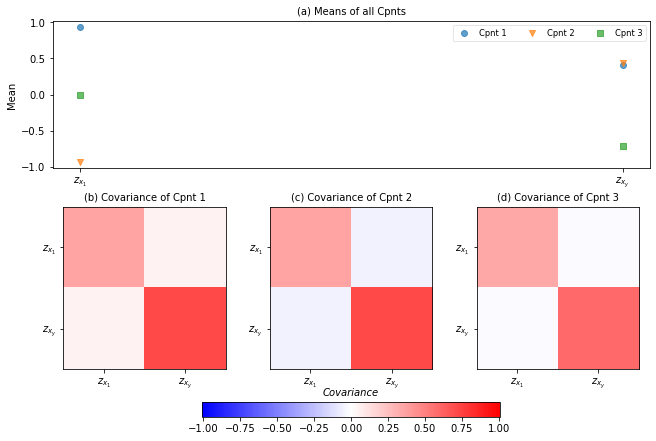

In [9]:
# Plot GMM used by a specific variable group (eg, the 1st)

var_name_ls = [r'${z_{x_{%d}}}$'%(i) for i in np.arange(1,nVar+1)]       # a list of all x variable names
var_name_ls.append(r'${z_{x_y}}$')                                       # append y variable name
ofile = os.path.join(outputDir,'gmm_mean_cov_x1_first.png')              # output figure file path

plot_gmm_mean_cov(fitted_gmm_ls_first[0], var_name_ls, sensType, GSAIndex[0], ofile)

### Part 3. Calculate total-order sensitivity indices using VISCOUS 

In [10]:
# Load raw data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Load standardized data
data = np.loadtxt(sampleStdFile, skiprows=0, delimiter=',')
zx   = data[:,0:-1]
zy   = data[:,-1].reshape(-1,1)    

# Specify VISCOUS configurations
sensType     = 'total'      # two options for sensitivity index calculation: 'first' or 'total' 

GSAIndex     = [[0]]        # Index 0 refers to the 1st input variable x1, meaning we aim to calculate the sensitivity index of x1.                     
                            # use vs.define_GSA_variable_index(nVar) if you want to compute each x variable' sensitivity indcies.
                            # use [[0],[1]] if you want to compute the sensitivity indices of x1 and x2.
        
N1, N2       = 1000, 1000   # Monte Carlo sample size. N1 is for outer loop, N2 is for inner loop.

n_components = 'optimal'    # The number of components used in GMM inference. An integer or string "optimal". 
                            # If n_components is an integer, it will be used as the fixed user-provided number of components.
                            # If n_components is "optimal", it will look for an optimal number of components in the range of [1, n_xvariables+20].


# Calculate sensitivity indeces using VISCOUS
sensIndex_total, fitted_gmm_ls_total = vs.VISCOUS(x, y, zx, zy, sensType, GSAIndex, N1, N2, n_components)  

Calculating total-effect sensitivity indices...
--- variable group [0] --- 
--- fitting GMM...
--- calculating sensitivity index...
--- Sensitivity index = 0.922856



#### Look at sensitivity indices and Gaussian mixture model (GMM) results

In [11]:
# Look at sensitivity indices 
for iGSA in range(len(GSAIndex)):
    if len(GSAIndex[iGSA])==1:
        print('ST%d = %.4f'%(GSAIndex[iGSA][0]+1, sensIndex_total[iGSA]))
    else:
        var_label = ''
        for ind in GSAIndex[iGSA]:
            var_label = var_label+'%d,'%(ind+1)
        var_label = var_label.rstrip(',')
        print('ST%s = %.4f'%(var_label, sensIndex_total[iGSA]))

ST1 = 0.9229


In [12]:
# Look at the best fitted GMM details of a specific variable group (eg, the 1st)
gmm = fitted_gmm_ls_first[0]
gmmWeights     = gmm.weights_            # shape (n_components,)
gmmMeans       = gmm.means_              # shape (n_components, n_variables). 
gmmCovariances = gmm.covariances_        # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents = gmm.n_components        # number of components
print('gmmNComponents = ',gmmNComponents)

gmmNComponents =  3


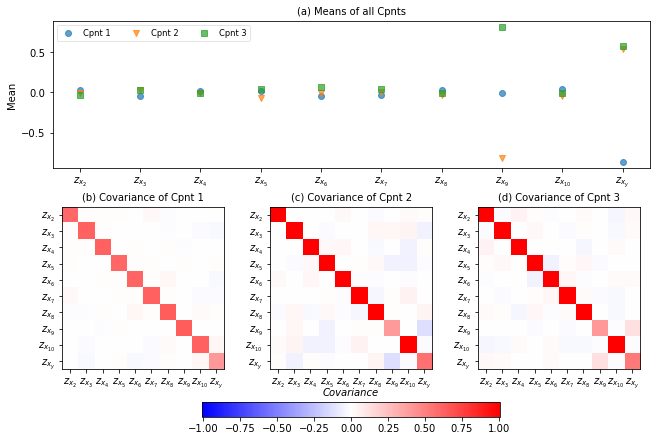

In [13]:
# Plot GMM used by a specific variable group (eg, the 1st)

var_name_ls = [r'${z_{x_{%d}}}$'%(i) for i in np.arange(1,nVar+1)]       # a list of all x variable names
var_name_ls.append(r'${z_{x_y}}$')                                       # append y variable name
ofile = os.path.join(outputDir,'gmm_mean_cov_x1_total.png')              # output figure file path

plot_gmm_mean_cov(fitted_gmm_ls_total[0], var_name_ls, sensType, GSAIndex[0], ofile)